In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from natsort import natsorted

## Get Data

In [2]:
def get_images(images_path):
    # speichert Bilder als numpy array

    array_images = []
    train_or_test_folder = os.listdir(images_path)

    for folder in natsorted(train_or_test_folder):
        single_folder = os.path.join(images_path, folder)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            if filepath.lower().endswith(('.jpeg', '.jpg')):
                image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                array_images.append(image)

    images = np.array(array_images)
    
    return images

In [3]:
def get_label(images_path):
    # speichert Lables als numpy array

    array_label = []
    for folder in natsorted(os.listdir(images_path)):
        label = int(folder)

        for file in os.listdir(os.path.join(images_path, folder)):
            array_label.append(label)
    labels = np.array(array_label)
        
    return labels

In [5]:
images = get_images("../../02_data_crop/train") # train images
labels = get_label("../../02_data_crop/train")  # train labels

X_eval = get_images("../../02_data_crop/test")  # Evaluierungs Bilder
y_eval = get_label("../../02_data_crop/test")   # Evaluierungs Labels

In [6]:
uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))
print("Anzahl eindeutiger Klassen: {}".format(len(uniq_labels)))

Anzahl eindeutiger Klassen: 26


## Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# von jeder Klasse Daten

n = len(uniq_labels)   # Anzahl eindeutiger Klassen
train_n = len(X_train) # Anzahl Trainingsdaten
test_n = len(X_test)   # Anzahl Testdaten
eval_n = len(X_eval)

tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Testbilder', test_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Testbilder            2074
Evaluierungsbilder    1448


In [9]:
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [10]:
print("One hot encoded: {}".format(y_train[0]))
print("Anzahl Klassen: {}".format(len(y_train[0])))
# Dummy Klasse, wenn kein Wert passt

One hot encoded: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Anzahl Klassen: 27


In [11]:
# Normalisierung der Bilder, damit Werte nur noch zwischen 0 und 1
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

## Model 1: VGG16

In [12]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [13]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [17]:
classifier1 = classifier_vgg16.output#head mode
classifier1= Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=27, activation='softmax')(classifier1)  # 27 units for 27 classes

model_vgg16 = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_vgg16.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,171 (58.16 MB)

 Trainable params: 531,483 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
#fit the model
history_vgg16 = model_vgg16.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 115s 835ms/step - accuracy: 0.1799 - loss: 2.8305 - val_accuracy: 0.5834 - val_loss: 1.5876
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 706ms/step - accuracy: 0.4880 - loss: 1.6845 - val_accuracy: 0.7261 - val_loss: 1.1690
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 688ms/step - accuracy: 0.6000 - loss: 1.3229 - val_accuracy: 0.7801 - val_loss: 0.9509
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 90s 696ms/step - accuracy: 0.6750 - loss: 1.0773 - val_accuracy: 0.8081 - val_loss: 0.7891
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 90s 695ms/step - accuracy: 0.7228 - loss: 0.9080 - val_accuracy: 0.8337 - val_loss: 0.6667


In [ ]:
# Saving the model of vgg16
model_vgg16.save('./Models/model_vgg16.h5')

In [20]:
score = model_vgg16.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model_vgg16.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 83.365 %
Accuracy for evaluation images: 71.202 %


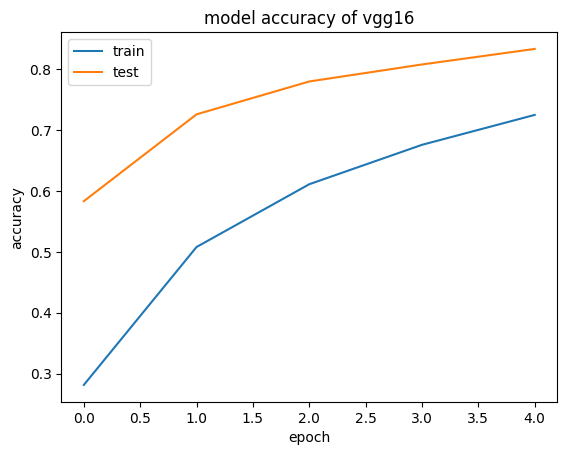

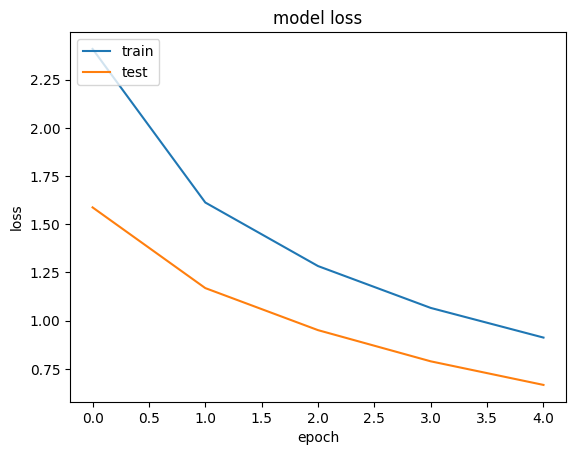

In [21]:
# summarize history for accuracy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

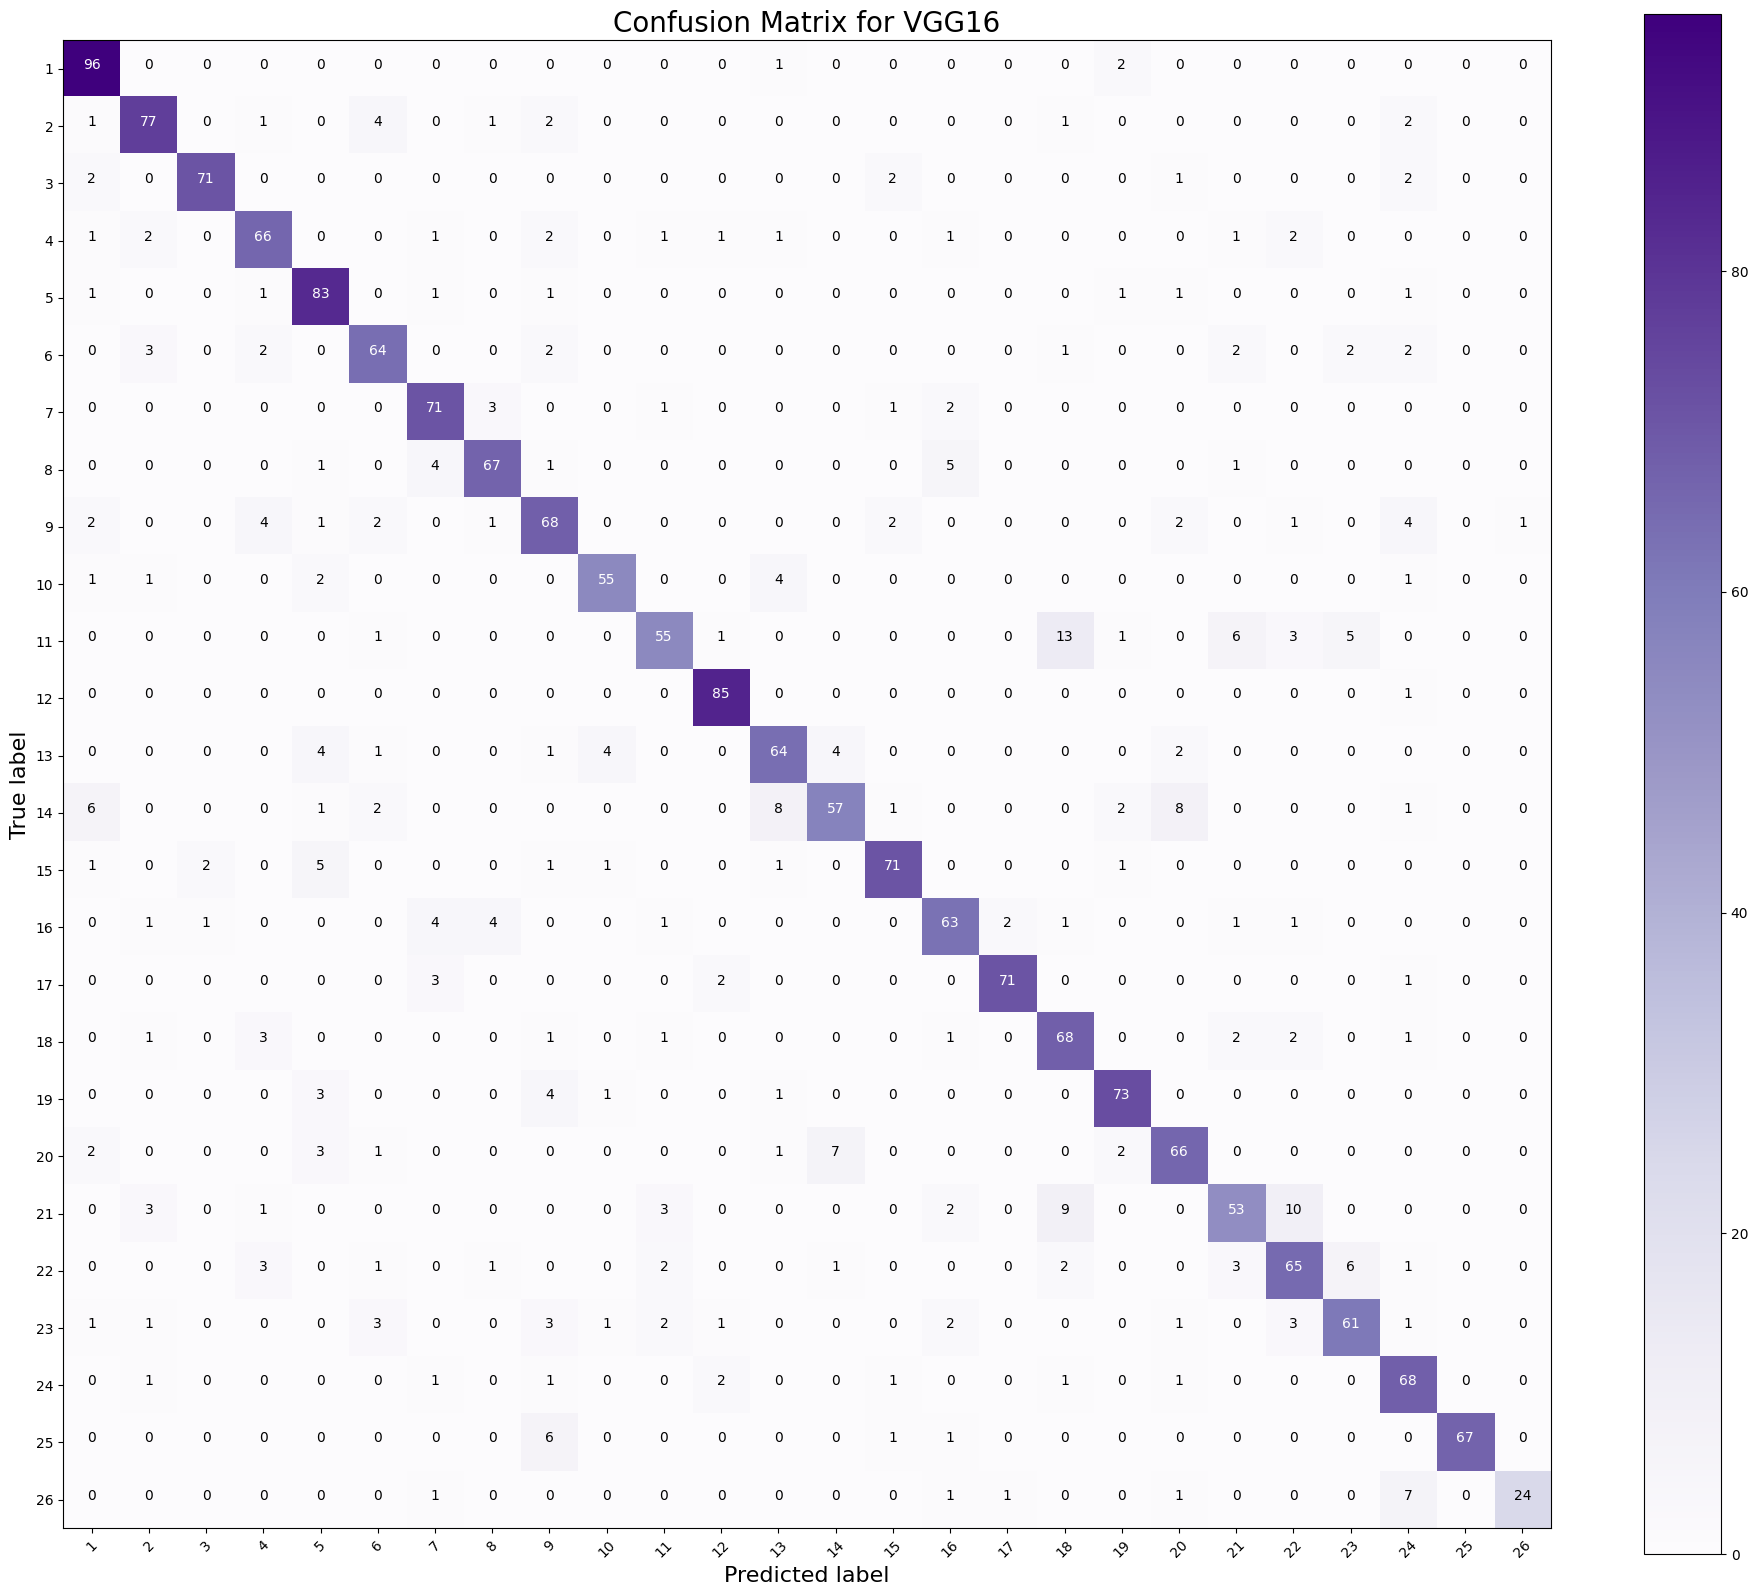

In [22]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix for VGG16")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model_vgg16.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

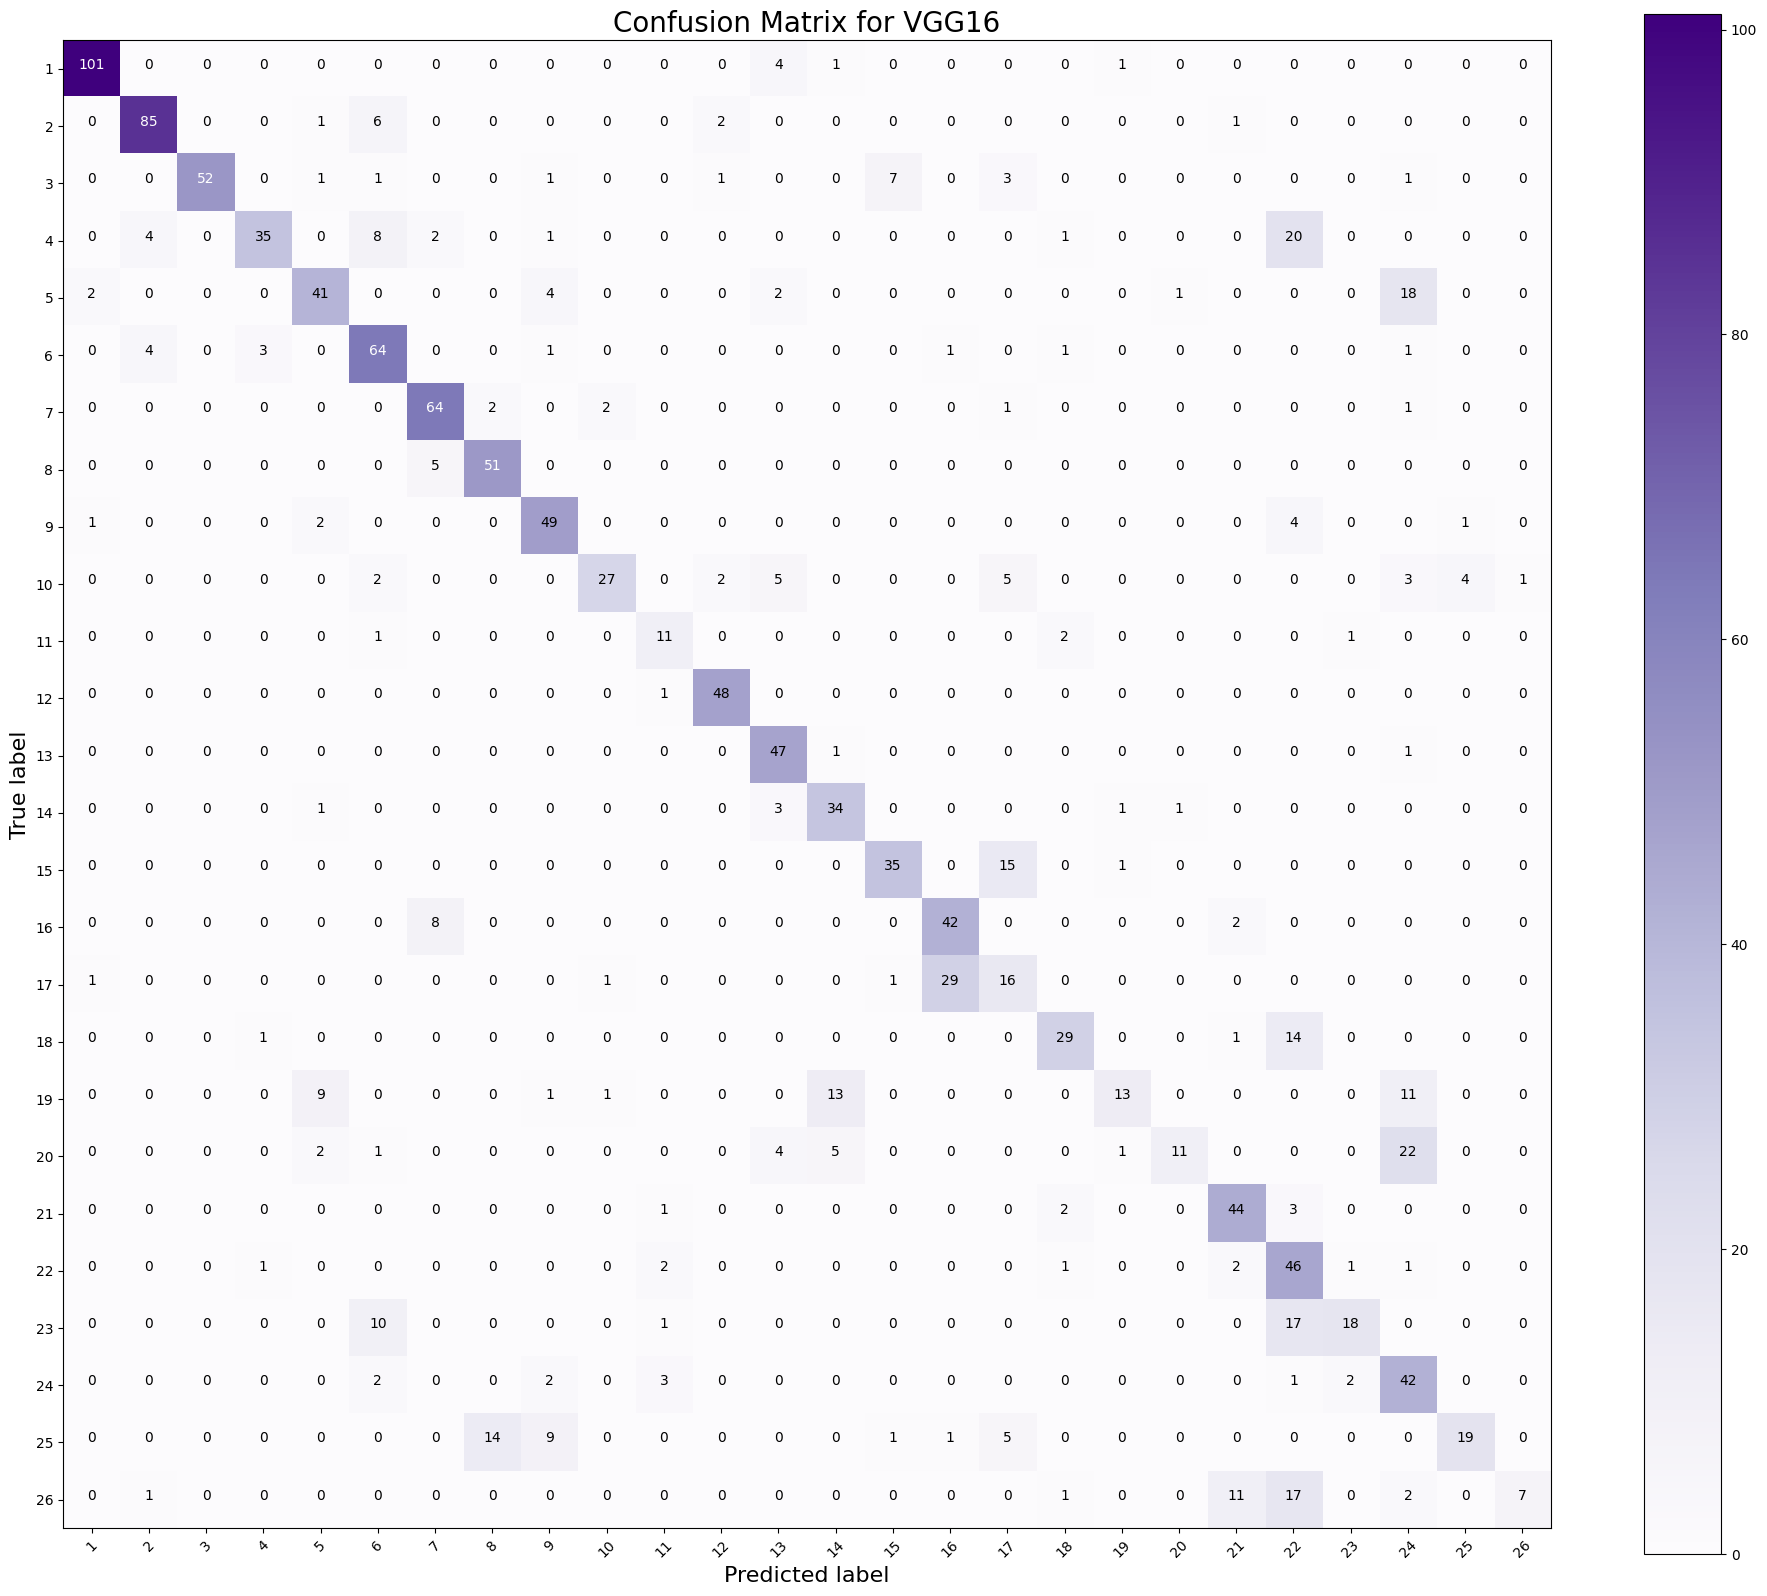

In [23]:
y_eval_pred = model_vgg16.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.3190857e-18 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
1.0
M


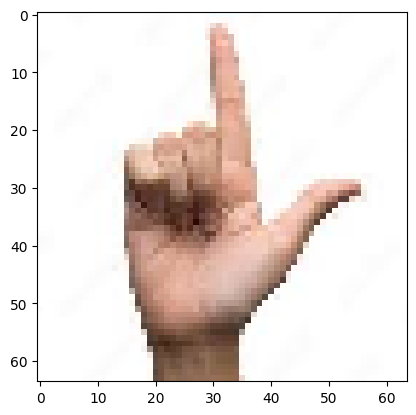

In [31]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('./l.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_vgg16.predict(test_image)
print(result[0])
print(result[0][12])


if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'


else:
    prediction = '  '
    
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Vorhergesagte Klasse:  M


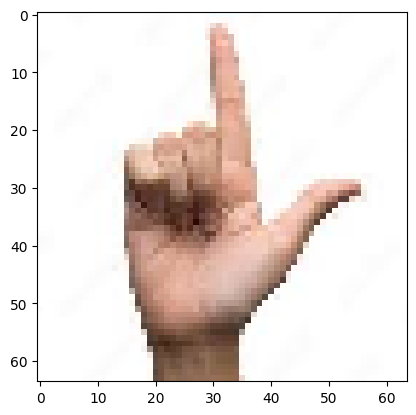

In [32]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('./l.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_vgg16.predict(test_image)

# Finde den Index des höchsten Werts in result
predicted_class_index = np.argmax(result)

# Lade die Klassenbezeichnungen
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # Füge hier deine Klassenbezeichnungen hinzu

# Zeige die Vorhersage an
print("Vorhergesagte Klasse: ", class_labels[predicted_class_index])